In [1]:

using Pkg
Pkg.activate(".")
using JuMP
using CSV
using GraphRecipes, Plots
using LightGraphs
using LinearAlgebra
using SparseArrays
using DataFrames
using Gurobi

  Activating environment at `~/Documents/project-codes/Plan_RoadmapsIAM/toy-problem/Project.toml`
┌ Info: Precompiling Gurobi [2e9cd046-0924-5485-92f1-d5272153d98b]
└ @ Base loading.jl:1342


In [87]:
innovations = CSV.File("./innovations.csv",header=1,delim=",") |> DataFrame
mapki = CSV.File("./map-ki.csv",header=1,delim=",") |> DataFrame
compromise = CSV.File("./compromise.csv",header=1,delim=",") |> DataFrame
initial = CSV.File("./initial.csv",header=1,delim=",") |> DataFrame
ci=innovations[!,2]
rl=innovations[!,3]
initial
innovations[2,6]=6

6

In [88]:
#using Pkg;
#Pkg.build("BARON")

In [89]:
function get_transition_mat(i)
    p_mat=reshape(collect(innovations[i,9:33]),5,5)
    return p_mat
end


function get_rate_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])'
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return q_mat
end

function get_IAM_factor(t)
    return 1
end

function give_sorted(t)
    v=sortperm(t)
    return v
end

function calc_tot_co2(x,t)
    v=give_sorted(t)
    for i in 1:(size(tk)[1]-1)
        print(initial[1,3]*tk[v][1]-sum(xk[v[j]]*tk[v][j+1]*(initial[1,3]-compromise[v,3][j]) for j in 1:i))
        print("\n")
    end
    return 1
end

function get_RL_atT(i,t)
    s0=[0 0 0 0 0]
    s0[i]=rl[i]
    q=get_rate_mat(i)
    #rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
    rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))
    #rl_t=sum([1 2 3 4 5].*(s0*(I+t*q)))
    return rl_t
end

get_RL_atT (generic function with 1 method)

In [90]:
function tech_roadmap()
    rdmap= Model(Gurobi.Optimizer)
    @variable(rdmap,yk[k=1:nrow(compromise)],Bin)
    @variable(rdmap,0 ≤ tk[k=1:nrow(compromise)] ≤ 50)
    @variable(rdmap,0 ≤ xk[k=1:nrow(compromise)] ≤ 1)
    @variable(rdmap,yi[i=1:nrow(innovations)],Bin)
    @variable(rdmap,0 ≤ ti[i=1:nrow(innovations)] ≤ 50)
    @variable(rdmap, 1 ≤ s[i=1:nrow(innovations)] )
    
    @variable(rdmap, co2_2050 ≥ 0)
    @variable(rdmap, co2_total ≥ 0)
    
    @constraint(rdmap, [i=1], sum(yk[k] for k=1:mapki[i,2])==yi[i])
    @constraint(rdmap, [i=2:nrow(mapki)], sum(yk[k] for k=mapki[i-1,2]:mapki[i,2])==yi[i])
    
    @constraint(rdmap, [i=1,k=1:mapki[i,2]], ti[i] ≤ tk[k])
    @constraint(rdmap, [i=2:nrow(mapki),k=mapki[i-1,2]:mapki[i,2]], ti[i] ≤ tk[k])
    
    @constraint(rdmap, [i=1:nrow(mapki)], 50*yi[i] ≥ ti[i])
    @constraint(rdmap, [k=1:nrow(compromise)], 50*yk[k] ≥ tk[k])
    
    @constraint(rdmap, [k=1:nrow(compromise)], yk[k] ≥ xk[k])
    @constraint(rdmap, sum(xk[k] for k in 1:nrow(compromise)) ≤ 1) 
    
    
    @constraint(rdmap, co2_2050==sum(xk[k]*compromise[k,3]*get_IAM_factor(tk[k]) for k in 1:nrow(compromise))
        + (1-sum(xk[k] for k in 1:nrow(compromise)))*initial[1,3])
    
    #@constraint(rdmap, co2_total == calc_tot_co2(xk,tk))
    
    @constraint(rdmap, [i=1:nrow(innovations)], s[i]==get_RL_atT(i,ti[i]))
    
    @constraint(rdmap, co2_2050 ≤ 73)
    
    @objective(rdmap,Min,sum(ci[i]*(yi[i]*(15-s[i])) for i in 1:nrow(innovations)))
    
    optimize!(rdmap)
    return JuMP.value.(yk), JuMP.value.(tk), JuMP.value.(xk), JuMP.value.(yi), JuMP.value.(ti), JuMP.value.(s), JuMP.value.(co2_2050)   
end

tech_roadmap (generic function with 1 method)

In [91]:
yk, tk, xk, yi, ti, s, co2=tech_roadmap()
yi

Set parameter Username
Academic license - for non-commercial use only - expires 2022-11-07
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 92 rows, 92 columns and 253 nonzeros
Model fingerprint: 0x7da111ae
Model has 5 quadratic objective terms
Model has 5 quadratic constraints
Variable types: 62 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  QMatrix range    [2e-02, 1e-01]
  QLMatrix range   [2e-01, 1e+00]
  Objective range  [1e+03, 2e+03]
  QObjective range [2e+02, 3e+02]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 1e+02]
  QRHS range       [2e+00, 1e+01]
Presolve removed 66 rows and 43 columns
Presolve time: 0.00s
Presolved: 26 rows, 49 columns, 120 nonzeros
Variable types: 25 continuous, 24 integer (24 binary)
Found heuristic solution: objective 1491.0000000

Root relaxation: objective 4.870000e+02, 35 iteration

┌ Warning: Axis contains one element: 1. If intended, you can safely ignore this warning. To explicitly pass the axis with one element, pass `[1]` instead of `1`.
└ @ JuMP.Containers /home/thakker.8/.julia/packages/JuMP/2IF9U/src/Containers/DenseAxisArray.jl:156


5-element Vector{Float64}:
 -0.0
  1.0
 -0.0
  0.0
 -0.0

In [92]:
tk

25-element Vector{Float64}:
  0.0
 -0.0
 -0.0
 -0.0
  0.0
 50.0
 -0.0
 -0.0
 -0.0
 -0.0
  0.0
 -0.0
 -0.0
 -0.0
  0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
  0.0
 -0.0
 -0.0
 -0.0
  0.0

In [93]:
co2

73.0

In [151]:
s

5-element Vector{Float64}:
  2.0
  6.0
  3.0
 12.0
  5.0

In [94]:
innovations

,i,Cost_per_RL,RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,92,2,4.6,1.34,2.04,0.12,8.86,0
2,2,122,3,8.32,8.84,6.0,9.9,9.65,0
3,3,78,1,4.44,1.21,5.09,6.52,8.67,0
4,4,131,3,5.48,7.62,3.34,5.05,5.6,0
5,5,95,1,9.94,2.38,7.94,3.82,5.44,0


In [35]:
i=1
eDtmc=[[collect(innovations[i,9:13])],[collect(innovations[i,9:13])]]

2-element Vector{Vector{Vector{Real}}}:
 [[0, 0.76, 0.21, 0.03, 0]]
 [[0, 0.76, 0.21, 0.03, 0]]

In [36]:
innovations[1,9:13]

,P11,P12,P13,P14,P15
,Int64,Float64,Float64,Float64,Int64
1,0,0.76,0.21,0.03,0


In [37]:
collect(innovations[i,9:13])

5-element Vector{Real}:
 0
 0.76
 0.21
 0.03
 0

In [38]:
g=get_rate_mat(3)

5×5 Matrix{Float64}:
 -0.321923    0.298347    0.0235756    0.0          0.0
  0.17027    -0.211907    0.0394892    0.00214724   0.0
  0.043018    0.483471   -0.557164     0.0306748    0.0
  0.0119369   0.0446281   0.125344    -0.297249     0.11534
  0.0         0.0         0.00805501   0.120552    -0.128607

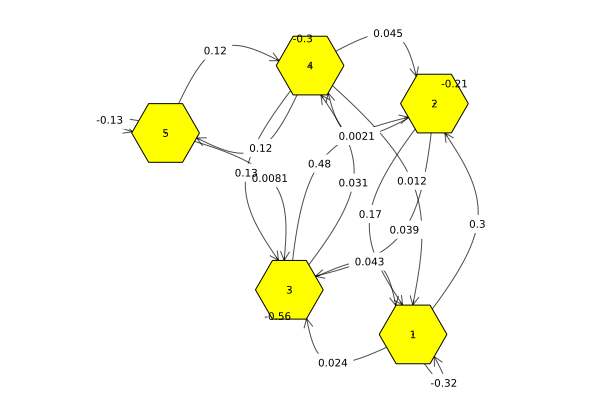

In [39]:
n = 5
edgelabel_dict = Dict()
edgelabel_mat = Array{String}(undef, n, n)
for i in 1:n
    for j in 1:n
        edgelabel_mat[i, j] = edgelabel_dict[(i, j)] = string(round(g[i,j],sigdigits=2)) 
    end
end
edgelabel_vec = edgelabel_mat[:]


graphplot(g, names=1:5, curvature_scalar=0.2,  edgelabel=edgelabel_dict, markersize = 0.5,
           linecolor = :darkgrey, markercolor = "yellow",
           linealpha = 0.7)

In [40]:
tt=4
g+tt*g^2/2+tt^3*g^3/6+tt^4*g^4/24

5×5 Matrix{Float64}:
 -0.423105     0.394385    0.0303724    -0.00188828   0.000235193
  0.225231    -0.279031    0.0518874     0.0022737   -0.000361583
  0.0525528    0.636447   -0.732158      0.0458914   -0.00273378
 -0.0296419    0.0464765   0.186124     -0.34269      0.139732
  0.00843334  -0.0192055   0.000215816   0.145855    -0.135298

In [41]:
exp(g*tt)

5×5 Matrix{Float64}:
 0.428317   0.519017   0.0474505  0.00446761  0.000747461
 0.285887   0.65056    0.0550515  0.00699953  0.00150122
 0.219469   0.591072   0.151541   0.0289299   0.00898843
 0.0811992  0.236423   0.115946   0.356784    0.209647
 0.0183684  0.0612607  0.0477347  0.219748    0.652888

-119.69962496882795

In [110]:
tk=vec([1 34 2 112 44])
xk=vec([0.1 0.32 0.2 0.11 0.4])

5-element Vector{Float64}:
 0.1
 0.32
 0.2
 0.11
 0.4

In [48]:
xk[give_sorted(tk)]
v=give_sorted(tk)
v
compromise

,k,i,GWP,Theta,Per_Recycl,Per_Comp
,Int64,Int64,Int64,Float64,Float64,Float64
1,1,1,80,0.6,0.5,0.0
2,2,1,86,0.66,0.55,0.0
3,3,1,91,0.68,0.567,0.0
4,4,1,95,0.7,0.583,0.0
5,5,2,60,0.4,0.0,0.2
6,6,2,64,0.48,0.0,0.24
7,7,2,68,0.5,0.0,0.27
8,8,2,76,0.52,0.0,0.34
9,9,2,80,0.54,0.0,0.37


In [108]:
q=get_rate_mat(2)
t=50
s0=[0 0 0 1 0]
(s0*(exp(q*t)))

1×5 Matrix{Float64}:
 0.394056  0.229994  0.212292  0.0619876  0.101671

In [49]:
for i in 1:size(tk)[1]
    print(sum(xk[v[j]] for j in 1:i))
    print("\n")
end

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0


In [99]:
size(tk)[1]

5

In [122]:
for i in 1:(size(tk)[1]-1)
    print(initial[1,3]*tk[v][1]-sum(xk[v[j]]*tk[v][j+1]*(initial[1,3]-compromise[v,3][j]) for j in 1:i))
    print("\n")
end

96.0
34.8
-162.32
-1954.3200000000002


In [116]:
apprx=I+get_rate_mat(4)*50

5×5 Matrix{Float64}:
 -3.2027     2.42126    1.78144     0.0        0.0
  6.87956   -9.21963    2.93413     0.405941   0.0
  1.78832    3.83202   -6.54113     1.92079    0.0
  0.456204   0.308399   9.49102   -18.1842     8.92857
  0.0        0.0        0.763473    7.57426   -7.33773

In [142]:
n1=[1 2 3 4 5].*[0 0 1 0 0]*apprx

1×5 Matrix{Float64}:
 5.36496  11.4961  -19.6234  5.76238  0.0

In [144]:
sum(n1)

3.0

In [148]:
i=4
s0=[0 0 0 0 0]
s0[i]=rl[i]
q=get_rate_mat(i)
apprx=I+q*50+1/2*t^2*q^2

5×5 Matrix{Float64}:
  15.5501   -11.6256     -5.12686    2.20233     0.0
 -40.0139    57.0139    -15.0679    -2.74423     1.81223
   4.9069   -27.7366     38.2231   -22.9683      8.57496
   4.66892   14.5115   -113.067    208.824    -113.937
   2.41037    2.63077    30.6456   -95.9216     61.2348

In [149]:
n1=[1 2 3 4 5].*[0 0 1 0 0]*apprx
sum(n1)

2.999999999999986

In [155]:
get_RL_atT(4,50)

-119.69962496882795